In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim

import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2




In [2]:
run_config_name = 'run_test_128_condQ_pylianscic_200c_lgMmin5e13.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)





In [3]:
config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp



In [4]:
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
    )

if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None



In [5]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])



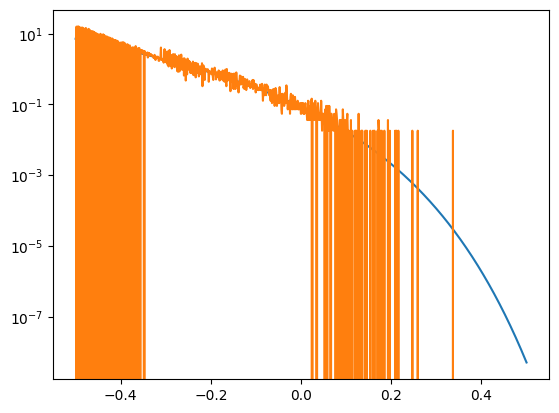

In [6]:
lgM_edges = 0.5*(lgM_rescaled[1:] + lgM_rescaled[:-1])
lgM_edges = np.append(lgM_edges, lgM_edges[-1] + (lgM_edges[-1] - lgM_edges[-2]) )
lgM_edges = np.insert(lgM_edges, 0, lgM_edges[0] - (lgM_edges[1] - lgM_edges[0]) )
indsel = np.where(np.array(return_dict_train['M_halos_all_sort_norm']) > -0.5)
lgM_hist_all = np.histogram(np.array(return_dict_train['M_halos_all_sort_norm'])[indsel], lgM_edges, density=True)[0]
lgM_centers = 0.5 * (lgM_edges[1:] + lgM_edges[:-1])

pl.figure()
pl.plot(lgM_rescaled, hmf_pdf)
pl.plot(lgM_rescaled, lgM_hist_all)
# pl.xscale('log')
pl.yscale('log')


In [7]:
num_cond_Ntot = num_cond
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist='pl_exp'    
    )

num_cond_M1 = num_cond + 1
# if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2



In [8]:
model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )




In [9]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    )

model.to(dev)



COMBINED_Model(
  (M1_model): NSF_M1_CNNcond(
    (layers): ModuleList(
      (0-1): 2 x FCNN(
        (network): Sequential(
          (0): Linear(in_features=13, out_features=3, bias=True)
          (1): Tanh()
          (2): Linear(in_features=3, out_features=3, bias=True)
          (3): Tanh()
          (4): Linear(in_features=3, out_features=14, bias=True)
        )
      )
    )
  )
  (Ntot_model): SumGaussModel(
    (layers): ModuleList()
    (layer_init): FCNN(
      (network): Sequential(
        (0): Linear(in_features=12, out_features=3, bias=True)
        (1): Tanh()
        (2): Linear(in_features=3, out_features=3, bias=True)
        (3): Tanh()
        (4): Linear(in_features=3, out_features=7, bias=True)
      )
    )
  )
  (Mdiff_model): NSF_Mdiff_CNNcond(
    (layers_all_dim): ModuleList(
      (0): ModuleList(
        (0-1): 2 x FCNN(
          (network): Sequential(
            (0): Linear(in_features=14, out_features=3, bias=True)
            (1): Tanh()
          

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)




In [11]:
save_bestfit_model_name = 'COND_HMF_CHECKPOINTS/TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim + \
                            '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
                            '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
print(save_bestfit_model_name)
print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
for g in optimizer.param_groups:
    g['lr'] = lr


COND_HMF_CHECKPOINTS/TEST_FINALS_SIMPLE_BATCHED_model_save_nsim1_cond_sim_quijote_nsd128_nc4_nsh128_mass_rockstar_200c_stype_cic_nsimperbatch32_nbatches16
loading bestfit model


In [12]:
if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)
Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)



In [13]:
train_Ntot = 1
train_M1 = 1
train_Mdiff = 1


In [14]:
Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
    cond_x=cond_tensor,
    cond_x_nsh=cond_tensor_nsh,
    use_truth_Nhalo=1-train_Ntot,
        use_truth_M1=1-train_M1,
        use_truth_Mdiff=1-train_Mdiff, 
    mask_Mdiff_truth=mask_tensor_Mdiff_train,
    mask_M1_truth=mask_tensor_M1_train,
    Nhalos_truth=X_Nhalo,
    M1_truth=X_M1,
    Mdiff_truth=X_Mdiff,
    train_Ntot=train_Ntot,
    train_M1=train_M1,
    train_Mdiff=train_Mdiff,
    x_M1_FP=X_M1_FP,   
    mask_M1_truth_all_FP=mask_tensor_M1_train_FP 
    )


/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:608: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


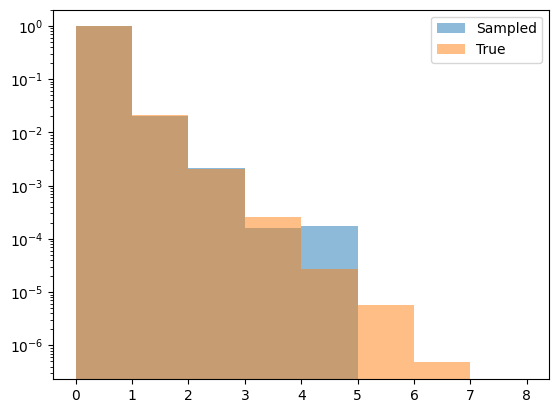

In [15]:
pl.figure()
_ = pl.hist(Ntot_samp_test[0].flatten(), bins=[0,1,2,3,4,5,6,7,8], density=True, alpha=0.5, label='Sampled')
_ = pl.hist(np.array(return_dict_train['N_halos_all']).flatten(), bins=[0,1,2,3,4,5,6,7,8], density=True, alpha=0.5, label='True')
pl.legend()
pl.yscale('log')



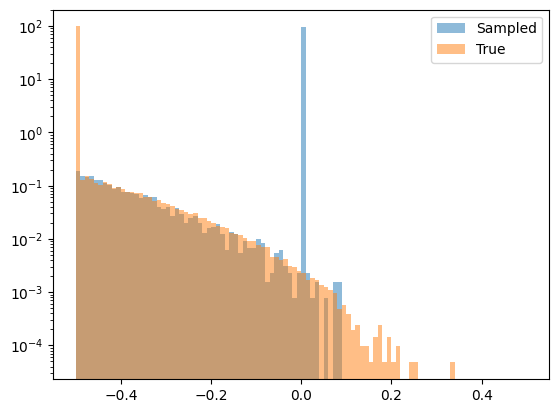

In [16]:
pl.figure()
_ = pl.hist(M1_samp_test[0].cpu().detach().numpy().flatten(), bins=100, range=(-0.5,0.5), density=True, alpha=0.5, label='Sampled')
_ = pl.hist(np.array(return_dict_train['M1_halos_all_norm']).flatten(), range=(-0.5,0.5), bins=100, density=True, alpha=0.5, label='True')
pl.legend()
pl.yscale('log')



In [17]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
ji = 0
# for ji in range(len(isim_all)):
saved_all_jsim = {}
# now we load the test data
isim = isim_all[ji]
print('DOING SIM NUMBER:' + str(isim))
nstart = 0
nsims_test = 32
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data_NGP(
    [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr
    )

if cond_sim == 'fastpm':
    df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
        stype=stype
        )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

# nfeatures_M1_tot = 20
# cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

nscount = 0
for jq in range(nq):
    # Load the density data


    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
    
    if cond_sim == 'fastpm':
        return_dict_test_FP = prep_density_halo_cats(
            df_d_all_test_FP,
            df_d_all_nsh_test_FP,
            df_Mh_all_test_FP,
            df_Nh_test_FP,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
            )    

    if cond_sim == 'fastpm':
        cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
        cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
        cond_nsh_test = np.array([cond_nsh_test])
        cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    else:
        cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
        cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
        cond_nsh_test = np.array([cond_nsh_test])
        cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                    1)))).cuda(dev)
    
    if cond_sim == 'fastpm':
        mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test_FP = torch.Tensor(
            (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test_FP = torch.Tensor(
            return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
    else:
        mask_tensor_M1_test_FP = None
        mask_tensor_Mdiff_test_FP = None
        X_M1_test_FP = None
        X_Nhalo_test_FP = None
        X_Mdiff_test_FP = None
        Nhalos_truth_tensor_test_FP = None

    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=1-train_Ntot,
            use_truth_M1=1-train_M1,
            use_truth_Mdiff=1-train_Mdiff, 
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        Mdiff_truth=X_Mdiff_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
        x_M1_FP=X_M1_test_FP,   
        mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
        )
    Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_M1_truth[nscount:nscount + nsims_test,
                ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                        ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
    # cond_inp_M1_all[nscount:nscount + nsims_test,
    #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
    # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
    # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

    save_subvol_Mdiff[nscount:nscount + nsims_test,
                    ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                    ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                    0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                    0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot_truth[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    # print(nscount, nscount + nsims_test)

    nscount += nsims_test
    torch.cuda.empty_cache()


save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot[...,
                        jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


save_subvol_Mtot *= mask_subvol_Mtot

ind_less_Mmin = save_subvol_Mtot < Mmin
ind_greater_Mmax = save_subvol_Mtot > Mmax
save_subvol_Mtot[ind_less_Mmin] = 0.0
save_subvol_Mtot[ind_greater_Mmax] = 0.0


save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot_truth[...,
                        jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
            


DOING SIM NUMBER:1


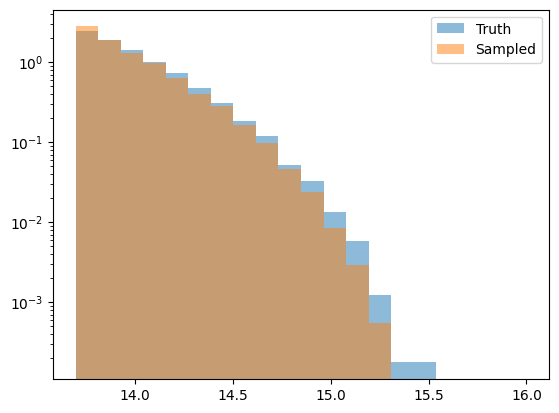

In [18]:
pl.figure()
_ = pl.hist(save_subvol_Mtot_truth[...,0].flatten(), bins=20, range=(lgMmin, lgMmax), density=True, alpha=0.5, label='Truth')
_ = pl.hist(save_subvol_Mtot[...,0].flatten(), bins=20, range=(lgMmin, lgMmax), density=True, alpha=0.5, label='Sampled')
pl.yscale('log')
pl.legend()



In [19]:
save_subvol_Mtot_truth.shape

(512, 16, 16, 16, 10)

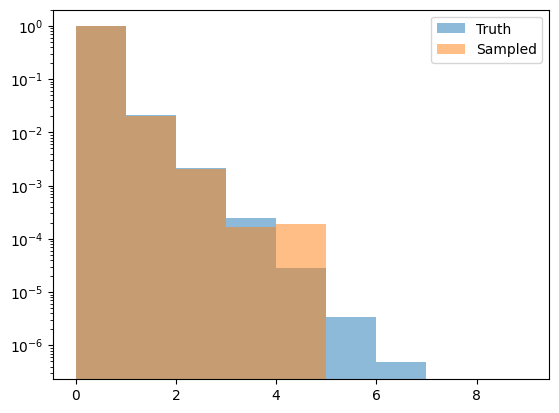

In [20]:
pl.figure()
_ = pl.hist(save_subvol_Nhalo_truth.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Truth')
_ = pl.hist(save_subvol_Nhalo.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Sampled')
pl.yscale('log')
pl.legend()
# df_Nh_truth_comb


In [21]:
# mass_type, ns_h
isim


1

In [22]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + mass_type + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=' + str(0) + '.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
saved_all_jsim['Nhalo_bin_cents'] = bin_cents
saved_all_jsim['Nhalo_bin_edges'] = bin_edges

delta_min_p, delta_max_p= -1.0, 500
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all

delta_min_p, delta_max_p= -1.0, 0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

delta_min_p, delta_max_p= 0.0, 2.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

delta_min_p, delta_max_p= 2.0, 500
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
bin_cents_M = np.linspace(lgMmin, lgMmax, 20)
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


delta_min_p, delta_max_p = -1.0, 500.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_all[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_all[idim, :] = hist_sampled
saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

delta_min_p, delta_max_p = -1.0, 0.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_low[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_low[idim, :] = hist_sampled
saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

delta_min_p, delta_max_p = 0.0, 2.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_mid[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_mid[idim, :] = hist_sampled
saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

delta_min_p, delta_max_p = 2.0, 500.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_high[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_high[idim, :] = hist_sampled
saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high



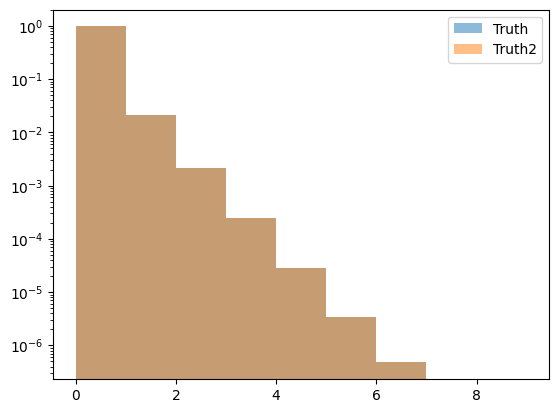

In [23]:
pl.figure()
_ = pl.hist(save_subvol_Nhalo_truth.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Truth')
_ = pl.hist(df_Nh_truth_comb.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Truth2')
# _ = pl.hist(df_Nh_truth.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Truth3')
# df_Nh_truth
# _ = pl.hist(save_subvol_Nhalo.flatten(), bins=np.arange(10), density=True, alpha=0.5, label='Sampled')
pl.yscale('log')
pl.legend()
# df_Nh_truth_comb
# hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)


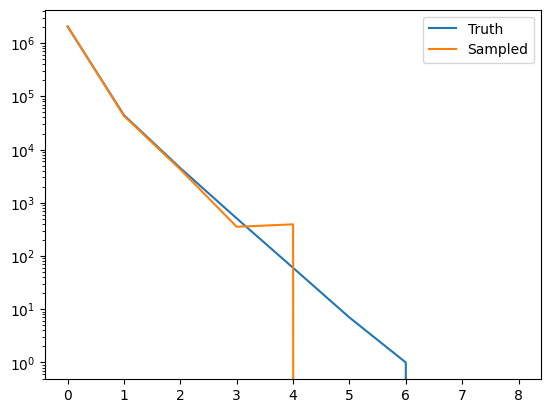

In [24]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_all_Nhalo'], label='Truth')
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_all_Nhalo'], label='Sampled')
pl.legend()
pl.yscale('log')




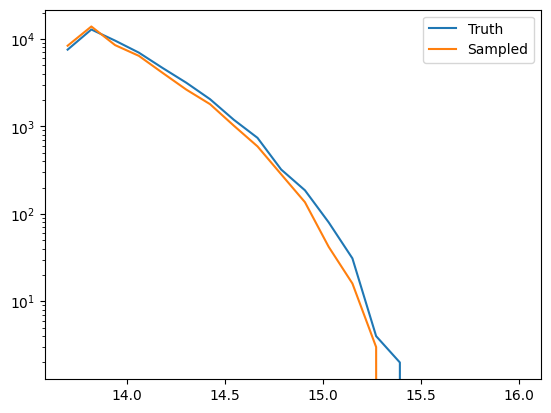

In [25]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][0,:], label='Truth')
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][0,:], label='Sampled')
pl.legend()
pl.yscale('log')
# df_Mh_all_truth, save_subvol_Mtot, save_subvol_Mtot_truth



In [27]:
saved_all_jsim['hist_samp_all_Mhalo'][0,:]/saved_all_jsim['hist_truth_all_Mhalo'][0,:]



/tmp/ipykernel_485254/2739188020.py:1: RuntimeWarning: invalid value encountered in divide
  saved_all_jsim['hist_samp_all_Mhalo'][0,:]/saved_all_jsim['hist_truth_all_Mhalo'][0,:]


array([1.10872448, 1.08261175, 0.88854036, 0.9189848 , 0.87910672,
       0.83465315, 0.87695312, 0.85654362, 0.79864865, 0.88161994,
       0.7311828 , 0.525     , 0.51612903, 0.75      , 0.        ,
              nan,        nan,        nan,        nan,        nan])

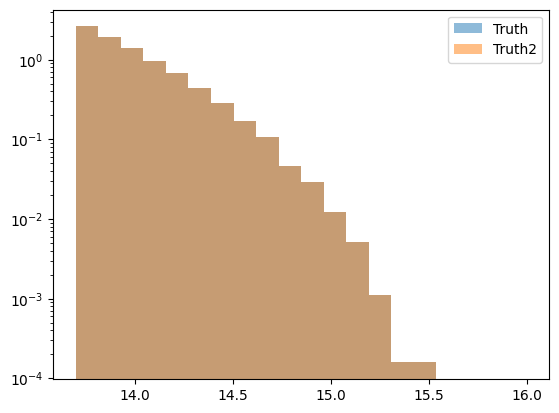

In [28]:
pl.figure()
_ = pl.hist(save_subvol_Mtot_truth.flatten(), bins=20, range=(lgMmin, lgMmax), density=True, alpha=0.5, label='Truth')
_ = pl.hist(df_Mh_all_truth.flatten(), bins=20, range=(lgMmin, lgMmax), density=True, alpha=0.5, label='Truth2')
pl.yscale('log')
pl.legend()



In [29]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
bin_cents_M = np.linspace(lgMmin, lgMmax, 20)
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


delta_min_p, delta_max_p = -1.0, 500.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_all[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_all[idim, :] = hist_sampled
saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

delta_min_p, delta_max_p = -1.0, 0.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_low[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_low[idim, :] = hist_sampled
saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

delta_min_p, delta_max_p = 0.0, 2.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_mid[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_mid[idim, :] = hist_sampled
saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

delta_min_p, delta_max_p = 2.0, 500.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_truth_high[idim, :] = hist_truth
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
    hist_M_samp_high[idim, :] = hist_sampled
saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high





In [31]:
ldir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_cic_mtype_rockstar_200c_condsim_quijote'
isim = 1
saved = pk.load(open(ldir + '/summary_stats_jsim_' + str(isim) + '.pk', 'rb'))
saved['hist_samp_all_Mhalo'][0,:]/saved['hist_truth_all_Mhalo'][0,:]



/tmp/ipykernel_485254/3685584614.py:4: RuntimeWarning: invalid value encountered in divide
  saved['hist_samp_all_Mhalo'][0,:]/saved['hist_truth_all_Mhalo'][0,:]


array([0.74250862, 0.71604649, 0.5829151 , 0.59994264, 0.60468113,
       0.57111182, 0.52929688, 0.58557047, 0.49189189, 0.6105919 ,
       0.41935484, 0.4625    , 0.41935484, 0.25      , 0.        ,
              nan,        nan,        nan,        nan,        nan])

In [ ]:
saved_all_jsim['hist_samp_all_Mhalo'][0,:]/saved_all_jsim['hist_truth_all_Mhalo'][0,:]